# Prepare

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install --upgrade torch
%pip install --upgrade torchtext
#%pip install --upgrade torchvision
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu113/torch_nightly.html -U
%pip install pytorch_lightning
%pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.3 MB 19 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.12.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.12.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.12.0 which is incompatible.
fastai 2.6.3 requires torch<1.12,>=1.7.0, but you have torch 1.12.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████

In [3]:
import sys
import os
module_path = os.path.join(os.path.abspath(''), "drive/MyDrive/Master_Thesis_Profactor/zdmp/")
if module_path not in sys.path:
  sys.path.append(module_path)

import zdmp
import pytorch_lightning
import torch
import torchvision

from torch.utils.data import DataLoader
import numpy as np
import warnings
import timm

# Select Model

In [ ]:
model_names = ["luna", "alexnet", "resnet", "efficientnetv2", "convnext", "vit", "swin_t"]
model_name = model_names[4]

In [ ]:
# Make the results reproducible
import pytorch_lightning as pl
pl.seed_everything(42)

# Prepare dataset
ds_train, ds_vali = zdmp.get_train_data(vit=(model_names.index(model_name)>=5))
ds_test = zdmp.get_test_data(vit=(model_names.index(model_name)>=5))

# Prepare Dataloaders
dl_train = DataLoader(ds_train, batch_size=32, num_workers=2, shuffle=True)
dl_vali = DataLoader(ds_vali, batch_size=32, num_workers=2)
dl_test = DataLoader(ds_test, batch_size=32, num_workers=2)

Global seed set to 42


zdmp - ViT size - False
get_data - ViT size - False
transform - ViT size - False


In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

# https://github.com/kamata1729/visualize-pytorch/blob/master/main.py

class GradCAM():
    def __init__(self, model, target_layer, use_cuda):
        self.model = model.eval()
        self.target_layer = target_layer
        self.use_cuda = use_cuda
        self.feature_map = 0
        self.grad = 0
        
        if self.use_cuda:
            self.model = self.model.cuda()
        
        for module in self.model.named_modules():
            if module[0] == target_layer:
                module[1].register_forward_hook(self.save_feature_map)
                module[1].register_backward_hook(self.save_grad)
    
    def save_feature_map(self, module, input, output):
        self.feature_map =  output.detach()
        
    def save_grad(self, module, grad_in, grad_out):
        self.grad = grad_out[0].detach()
        
    def __call__(self, x, index=None):
        if self.use_cuda:
            x = x.cuda()
        with torch.autograd.detect_anomaly():
            output = self.model(x)
            if index==None:
                index = output.argmax(dim=1)
                
            self.model.zero_grad()
            (F.one_hot(index, 2) * output).sum().backward()

            cam = F.relu((self.feature_map[0] * (self.grad.mean(dim=(2,3))[0, :])[:, None, None]).sum(dim=0))

            print(f"Max: {cam.max()}")
            # Normalized between 0 and 1
            cam = cv2.resize((cam/cam.max()).cpu().numpy(), (x.shape[-2], x.shape[-1]))

            # Without normalization
            #cam = cv2.resize((cam).cpu().numpy(), (x.shape[-2], x.shape[-1]))
            return cam, index

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)/255
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [ ]:
model_names = ["luna", "alexnet", "resnet", "efficientnetv2", "convnext", "vit", "swin_t"]
model_name = model_names[4]

if model_name == model_names[0]:
    # Luna
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/luna_2022_6_4.pth")
    layer = 'block4.maxpool'
elif model_name == model_names[1]:
    # AlexNet
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/alexnet_2022_6_4.pth")
    
    #model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/alexnet_frozen_2022_6_9.pth")
    
    #model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    #model.classifier[6] = torch.nn.Linear(4096, 2)
    
    layer = 'features.11'
    threshold = 0.35
elif model_name == model_names[2]:
    # ResNet
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/resnet_2022_6_4.pth")
    #layer = 'layer4.0.conv2'
    layer = 'layer4.0.downsample.0'
    threshold = 0.45
elif model_name == model_names[3]:
    # EfficientNetV2
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/efficientnetv2_2022_6_4.pth")

    #model = torchvision.models.efficientnet_v2_s(weights="EfficientNet_V2_S_Weights.IMAGENET1K_V1")
    #model.classifier = torch.nn.Linear(1280, 2)

    layer = 'features.6.6.block.3' # Grande pero bueno
    layer = 'features.6.0.block.0.2'
    layer = 'features.5.6.block.0'
    layer = 'features.6.8.block.0'
    layer = 'features.6.0.block.0'
elif model_name == model_names[4]:
    # ConvNeXt
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/convnext_2022_6_4.pth")
    
    layer = 'features.7.2.block.0'
    layer = 'features'
    #layer = 'features.5.8.block.0' # Este esta bueno

    #layer = 'features.3.2'
    #layer = 'features.4'
    #layer = 'features.5.1'

    #layer = 'features.5.7.block.6' # MUY GRANDE


elif model_name == model_names[5]:
    # ViT
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/vit_2022_6_4.pth")
    layer = 'blocks.11.attn.qkv'
elif model_name == model_names[6]:
    # Swin
    model = torch.lead("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/swin_t_2022_6_4.pth")
    layer = None
elif model_name == model_names[7]:
    # DINO
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/dino_2022_6_4.pth")
    layer = None

model.eval()

for module in model.named_modules():
    print(module[0])
    #if module[0] == layer:
    #    print(module)

grad_cam_convnext = GradCAM(model, layer, False)


features
features.0
features.0.0
features.0.1
features.1
features.1.0
features.1.0.block
features.1.0.block.0
features.1.0.block.1
features.1.0.block.2
features.1.0.block.3
features.1.0.block.4
features.1.0.block.5
features.1.0.block.6
features.1.0.stochastic_depth
features.1.1
features.1.1.block
features.1.1.block.0
features.1.1.block.1
features.1.1.block.2
features.1.1.block.3
features.1.1.block.4
features.1.1.block.5
features.1.1.block.6
features.1.1.stochastic_depth
features.1.2
features.1.2.block
features.1.2.block.0
features.1.2.block.1
features.1.2.block.2
features.1.2.block.3
features.1.2.block.4
features.1.2.block.5
features.1.2.block.6
features.1.2.stochastic_depth
features.2
features.2.0
features.2.1
features.3
features.3.0
features.3.0.block
features.3.0.block.0
features.3.0.block.1
features.3.0.block.2
features.3.0.block.3
features.3.0.block.4
features.3.0.block.5
features.3.0.block.6
features.3.0.stochastic_depth
features.3.1
features.3.1.block
features.3.1.block.0
featu

In [ ]:
import matplotlib.pyplot as plt
torch.set_printoptions(precision=2)

def to_PIL(img, mean=[0.5643], std=[0.2386]):
  trans = torchvision.transforms.ToPILImage()
  img =  img * torch.tensor([std])[:, None, None] + torch.tensor([mean])[:, None, None]
  return trans(img.squeeze())

def norm(img, mean=[0.5643], std=[0.2386]):
  img =  img * torch.tensor([std])[:, None, None] + torch.tensor([mean])[:, None, None]
  return img.squeeze().permute(1,2,0)

('/content/drive/MyDrive/Master_Thesis/Casting_Product_Quality_Inspection/casting_data/casting_data/test/def_front/cast_def_0_1618.jpeg', 0)
Max: 0.07033456116914749


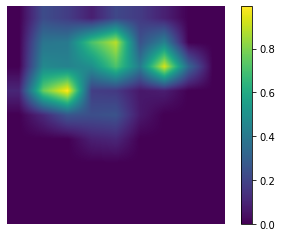

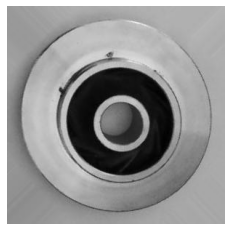

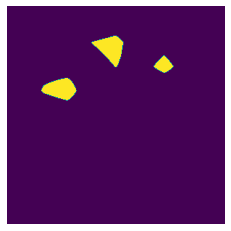

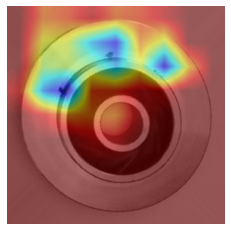

In [ ]:

threshold = 0.7
# 120, 155
ind = 120
img, _ = ds_test[ind]
print(ds_test.samples[ind])
cam, target_index = grad_cam_convnext(img.unsqueeze(0))

plt.imshow(cam)
plt.colorbar()
plt.axis('off')
plt.show()

plt.imshow(to_PIL(img))
plt.axis('off')
plt.show()

plt.imshow(cam>threshold)
plt.axis('off')
plt.show()

plt.imshow(show_cam_on_image(to_PIL(img), cam))
plt.axis('off')
plt.show()

('/content/drive/MyDrive/Master_Thesis/Casting_Product_Quality_Inspection/casting_data/casting_data/test/def_front/cast_def_0_1618.jpeg', 0)
Max: 0.07033456116914749
120 features


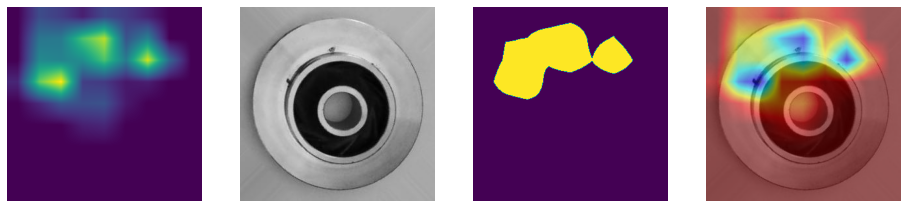

Max: 0.00037547750980593264
120 features.0


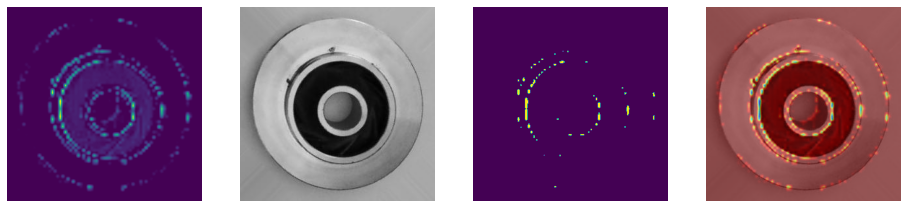

Max: 0.000621171435341239
120 features.0.0


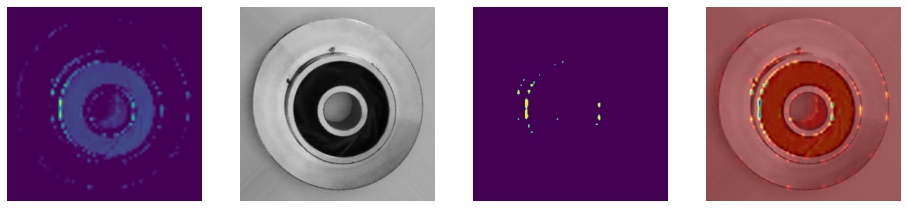

Max: 0.00037547750980593264
120 features.0.1


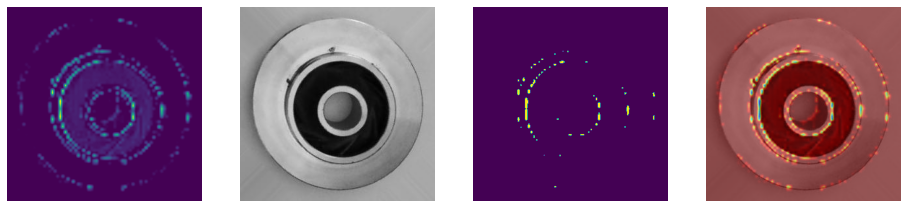

Max: 0.0004278559354133904
120 features.1


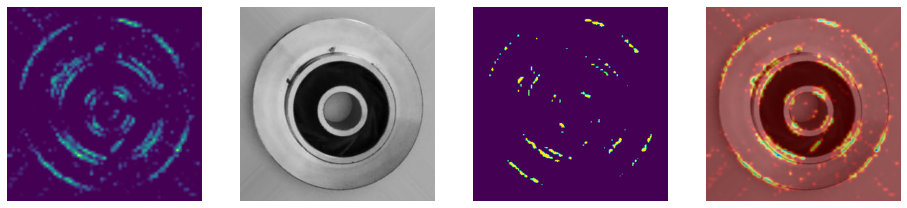

KeyboardInterrupt: ignored

In [ ]:

threshold = 0.4
# 120, 155
ind = 120
img, _ = ds_test[ind]
print(ds_test.samples[ind])

#########################################################################
for module in model.named_modules():
    layer = module[0]
    
    grad_cam_convnext = GradCAM(model, layer, False)
    #########################################################################

    try:
        img, _ = ds_test[120]
        cam, target_index = grad_cam_convnext(img.unsqueeze(0))

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
        ax1.imshow(cam)
        #ax1.colorbar()
        ax1.axis('off')
        
        ax2.imshow(to_PIL(img))
        ax2.axis('off')
        
        ax3.imshow(cam>threshold)
        ax3.axis('off')
        
        ax4.imshow(show_cam_on_image(to_PIL(img), cam))
        ax4.axis('off')

        print(120, layer)

        plt.show()

        #img, _ = ds_test[708]
        #cam, target_index = grad_cam_convnext(img.unsqueeze(0))

        #fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
        #ax1.imshow(cam)
        #ax1.axis('off')
        
        #ax2.imshow(to_PIL(img))
        #ax2.axis('off')
        
        #ax3.imshow(cam>threshold)
        #ax3.axis('off')
        
        #ax4.imshow(show_cam_on_image(to_PIL(img), cam))
        #ax4.axis('off')

        #print(710, layer)
        #plt.show()
    except Exception as e:
        pass
        #print(f'This layer does not work: {layer} \t\t {e}')

print(model_name)

In [ ]:
iou_total = 0
iop_total = 0
n = 0
threshold = 0.5

sum_cam = [None]*453
sum_mask = [None]*453

for i, (name, lbl) in enumerate(ds_test.samples):
    if lbl == 0:
        n += 1
        img, _ = ds_test[i]
        cam, target_index = grad_cam_convnext(img.unsqueeze(0).cpu(), index=torch.Tensor([0]).long())
        mask = plt.imread('/content/drive/MyDrive/Master_Thesis/DefectPosition/'+name.split('/')[-1].split('.')[0]+"_color_mask.png")

        sum_cam[n] = cam.sum()
        sum_mask[n] = mask.sum()

        intersection = (mask[:, :, 1]==0) & (cam>threshold)
        union = (mask[:, :, 1]==0) | (cam>threshold)

        if union.sum() != 0:
            iou = intersection.sum() / union.sum()
            iou_total += iou

            iop = intersection.sum() / max((cam>threshold).sum(), 1)
            iop_total += iop

        print(f"{n}\t {i} \tIoU: {iou:.2f} -> {iou_total:.2f}\tIoP:{iop:.2f} -> {iop_total:.2f}\t\t{name.split('/')[-1].split('.')[0]}_color_mask.png")
        
        if True:
            fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(28, 4))
            ax1.imshow(to_PIL(img))
            ax2.imshow(mask)
            ax3.imshow(mask[:, :, 1] == 0)
            ax4.imshow(cam)
            ax5.imshow(cam>threshold)
            ax6.imshow(union)
            ax7.imshow(intersection)
            ax1.axis('off')
            ax2.axis('off')
            ax3.axis('off')
            ax4.axis('off')
            ax5.axis('off')
            ax6.axis('off')
            ax7.axis('off')
            plt.show()

            #if n >= 10:
            #    break
        
print(iou_total, iop_total)

Output hidden; open in https://colab.research.google.com to view.

* Luna
  * Block4.maxpool - Threshold = 0.4
    * IoU - 23.69
    * IoP - 59.94

* AlexNet  Finetuned / Pretrained NO train on last layer
  * Features.11 - Threshold = 0.4
    * IoU - 34.20 / 15.13
    * IoP - 52.39 / 25.11
  * Features.11 - Threshold = 0.5
    * IoU - 31.71
    * IoP - 56.45

* Resnet 
  * layer4.0.downsample.0 - Threshold = 0.4
    * IoU - 54.69 / 2.30
    * IoP - 75.66 / 4.65

* EfficientNet
  * features.6.0.block.0 - Threshold = 0.4
    * IoU - 67.55 / 3.98
    * IoP - 181.04 / 9.29

* ConvNeXt
  * features.5.1 - Threshold = 0.4
    * IoU - 30.71 / 12.83
    * IoP - 65.66 / 41.99
  * features.7.2.block.0
    * IoU - 26.14 
    * IoP - 49.53 

* ViT
  * Encoder layer 6 - Attn Head 9 - Threshold = 0.4
    * IoU - 25.38
    * IoP - 77.63
  * Encoder layer 6 - Mean - Threshold = 0.4
    * IoU - 33.89
    * IoP - 81.50

* Swin Transformer
  * asdf
    * IoU - 
    * IoP - 

* DINO
  * Last Self Attention
    * IoU - 50.72
    * IoP - 204.16

In [ ]:
layer

'features.7.2.block.0'

In [ ]:
iou_total

12.895984333953022

# GradCAM - Jacobgil

In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.8 MB 3.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.9-py3-none-any.whl size=25984 sha256=c766766faa1aaa82b1a0279fba7e597b1144af7a0d3b0a7c0853ce4541a15c5c
  Stored in directory: /root/.cache/pip/wheels/65/e8/6e/6eedfbe3f0007dfd8116e6820b69691c4103d89ad2ae8c69ff
Successfully built grad-cam


90000


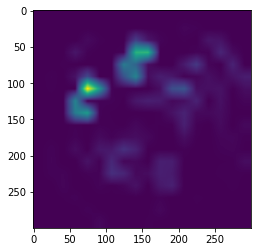

In [ ]:
from pytorch_grad_cam import GradCAM

# 120, 155
ind = 120
img, _ = ds_test[ind]

if model_name == "luna":
    layer = [model.block4.maxpool]

cam = GradCAM(model=model, target_layers=layer, use_cuda=True)

out = cam(img.unsqueeze(0))
print(out.size)
plt.imshow(out[0])

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# CAPTUM

In [ ]:
!pip install captum
from captum.attr import GuidedGradCam, IntegratedGradients, LayerGradCam

In [ ]:
img, _ = ds_test[120]

x = img.unsqueeze(0)
x.requires_grad_(True)

tensor([[[[ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          [ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          [ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          ...,
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473],
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473],
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473]],

         [[ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          [ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          [ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          ...,
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473],
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473],
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473]],

         [[ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          [ 0.1665,  0.1665,  

In [ ]:
model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/resnet.pth")
layer = 'layer4.1.conv2'

layer_gc = LayerGradCam(model, model.layer4[1].conv2)
attribution = layer_gc.attribute(x, 0)

#attr_alg = IntegratedGradients(model)
#attributions = attr_alg.attribute(x, target=0)

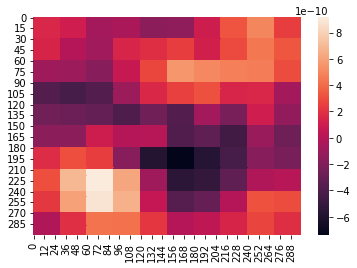

In [ ]:
from captum.attr import LayerAttribution


at = LayerAttribution.interpolate(attribution, (300, 300))

sns.heatmap(at[0][0].detach())

In [ ]:
att = (attributions + torch.abs(torch.min(attributions)))
att = att / torch.abs(torch.max(att))

In [ ]:
torch.max(att)

tensor(1., dtype=torch.float64, grad_fn=<MaxBackward1>)

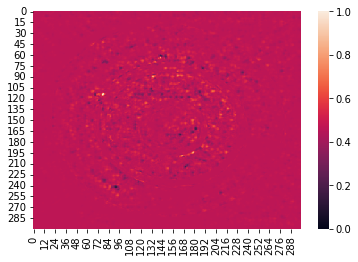

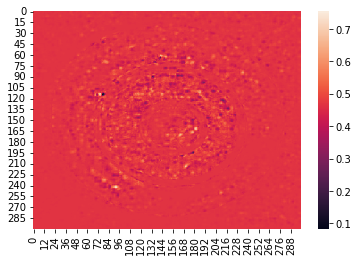

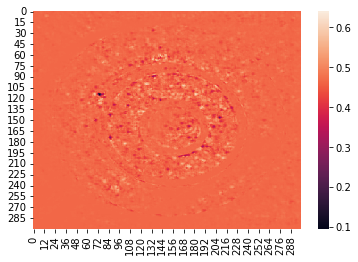

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


#plt.imshow(att[0].permute(1, 2, 0).detach().numpy())
sns.heatmap(att[0][0].detach().numpy())
plt.show()
sns.heatmap(att[0][1].detach().numpy())
plt.show()
sns.heatmap(att[0][2].detach().numpy())
plt.show()

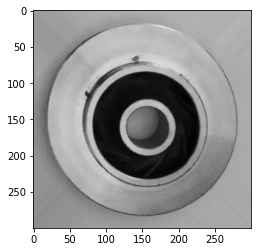

In [ ]:
plt.imshow(img.permute(1, 2, 0) * 0.2386 + 0.5643)

# Cosine Similarity

In [ ]:
model_names = ["luna", "alexnet", "resnet", "efficientnetv2", "convnext", "vit", "swin_t"]
model_name = model_names[1]

if model_name == model_names[0]:
    # Luna
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/luna_2022_6_4.pth")
    
elif model_name == model_names[1]:
    # AlexNet
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/alexnet_2022_6_4.pth")
    model_f = torchvision.models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1")
elif model_name == model_names[2]:
    # ResNet
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/resnet_2022_6_4.pth")
    model_f = torchvision.models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
elif model_name == model_names[3]:
    # EfficientNetV2
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/efficientnetv2_2022_6_4.pth")
    model_f = torchvision.models.efficientnet_v2_s(weights="EfficientNet_V2_S_Weights.IMAGENET1K_V1")
elif model_name == model_names[4]:
    # ConvNeXt
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/convnext_2022_6_4.pth")
    model_f = torchvision.models.convnext_tiny(weights="ConvNeXt_Tiny_Weights.IMAGENET1K_V1")
elif model_name == model_names[5]:
    # ViT
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/vit_2022_6_4.pth")
    model_f = torchvision.models.vit_b_16(weights="ViT_B_16_Weights.IMAGENET1K_V1")
elif model_name == model_names[6]:
    # Swin
    model = torch.lead("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/swin_t_2022_6_4.pth")
    model_f = torchvision.models.swin_t(weights="Swin_T_Weights.IMAGENET1K_V1")
elif model_name == model_names[7]:
    # DINO
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/dino_2022_6_4.pth")
    layer = None

model.eval()
model_f.eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
cos = torch.nn.CosineSimilarity(dim=0)

with torch.no_grad():
    for i, (param, param_f) in enumerate(zip(model.parameters(), model_f.parameters())):
        if param.shape == param_f.shape:
            print(i, cos(param.view(-1), param_f.view(-1)))
        else:
            print(i, "Non-compatible shapes: ", param.shape, param_f.shape)

0 tensor(1.0000)
1 tensor(1.0000)
2 tensor(0.9995)
3 tensor(1.0000)
4 tensor(0.9975)
5 tensor(0.9992)
6 tensor(0.9894)
7 tensor(0.9999)
8 tensor(0.9823)
9 tensor(0.9998)
10 tensor(0.7472)
11 tensor(0.9453)
12 tensor(0.6919)
13 tensor(0.9546)
14 Non-compatible shapes:  torch.Size([2, 4096]) torch.Size([1000, 4096])
15 Non-compatible shapes:  torch.Size([2]) torch.Size([1000])


In [ ]:
loss = torch.nn.CrossEntropyLoss()

type(loss)

torch.nn.modules.loss.CrossEntropyLoss

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF

torch.set_printoptions(precision=2)

img = Image.open("/content/drive/MyDrive/DefAnnotation/HandMadeDef/cast_ok_0_904_DEF.jpeg")
x = TF.to_tensor(img)
x.unsqueeze_(0)

print((torch.nn.Softmax()(model(x))).argmax(dim=1))

img = Image.open("/content/drive/MyDrive/Master_Thesis/Casting_Product_Quality_Inspection/casting_data/casting_data/test/ok_front/cast_ok_0_904.jpeg")
x = TF.to_tensor(img)
x.unsqueeze_(0)

print((torch.nn.Softmax()(model(x))).argmax(dim=1))

tensor([0])
tensor([1])
